In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


from scipy import linalg as LA
from scipy.signal import cont2discrete
import control as ct



import QPMatrices as QP
from system_model import system_model
from cost_function_parameter import cost_function_parameter

In [2]:



Ac, Bc, Cc, Dc = system_model()
print("A = {}, \n B = {}, \n C =  {}".format(Ac, Bc, Cc))

A = [[-0.01587302  0.          0.02564103  0.        ]
 [ 0.         -0.01098901  0.          0.01785714]
 [ 0.          0.         -0.02564103  0.        ]
 [ 0.          0.          0.         -0.01785714]], 
 B = [[0.04822143 0.        ]
 [0.         0.03495625]
 [0.         0.07755   ]
 [0.05593125 0.        ]], 
 C =  [[0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]]


In [3]:
# Discretized system using Scipy package using ZOH method




# Sampling period for the system
Ts = 2.0


disc_sys = cont2discrete((Ac, Bc, Cc, Dc), Ts, method='zoh')



# We unpack the tuple here
(A, B, C, D) = disc_sys[0:4]

print("A = {}, \n B = {}, \n C =  {} \n D = {}".format(A, B, C, D))




A = [[0.96875258 0.         0.04919749 0.        ]
 [0.         0.97826174 0.         0.03469906]
 [0.         0.         0.95001068 0.        ]
 [0.         0.         0.         0.96491594]], 
 B = [[0.09492809 0.00386858]
 [0.00195955 0.06914983]
 [0.         0.1511902 ]
 [0.10988852 0.        ]], 
 C =  [[0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]] 
 D = [[0. 0.]
 [0. 0.]]


In [4]:
# Here we want to form the matrices for the LQ in compact form



# The cost function parameters
n = np.size(A, 0)
m = np.size(B, 1)
p = np.size(C, 0)




P, Q, R, umax, umin, ymax, ymin = cost_function_parameter(n, m , p)









low_range_N = 10
up_range_N = 80

Error_A = np.zeros((1, up_range_N-low_range_N))
Error_B = np.zeros((1, up_range_N-low_range_N))
Error_R = np.zeros((1, up_range_N-low_range_N))
Error_Y = np.zeros((1, up_range_N-low_range_N))
Zero_location = np.zeros((2, up_range_N-low_range_N ), dtype=complex)

# Compute Y_inf using Lyapunov equation
Y_inf = LA.solve_discrete_lyapunov(A.T, Q)

for N in range(low_range_N, up_range_N):
    # Here we compute the Compact matrices given in the paper; note we need to 
   # compute them only once
    H, F, Y, G, W, O, calS, calR, calQ, S, calT = QP.QP_matrices(N, A, B, C,
                                                              P, Q, R, umin, umax, ymin, ymax)

    calC = F[:, :n* m]
    calC_plus = F[:, m:(n+1)*m]
    H_part = H[m:(n+1)*m, 0:m]
    


    Ahat = (calC_plus @ LA.pinv(calC)).T
    Bhat = (H_part.T @ LA.pinv(calC)).T 
    
    Ybar_B =  LA.pinv(Ahat.T) @ (0.5 * F[:, :m])
    Rhat =  (0.5 * H[0:m, 0:m]  - Bhat.T @ Ybar_B)
    

    # computing the zeros for the system 
    Gd = ct.ss(Ahat, Bhat, C, D, dt=True)
    z = ct.zeros(Gd)

    # Saving the results for the computation
    Error_A[:, N - low_range_N] = LA.norm(A-Ahat, ord='fro')/LA.norm(A, ord='fro')
    Error_B[:, N - low_range_N] = LA.norm(B-Bhat, ord='fro')/LA.norm(B, ord='fro')
    Error_R[:, N - low_range_N] = LA.norm(R-Rhat, ord='fro')/LA.norm(R, ord='fro')
    Error_Y[:, N - low_range_N] = LA.norm(Y_inf-Y, ord='fro')/LA.norm(Y_inf, ord='fro')
    Zero_location[:, N - low_range_N] = z



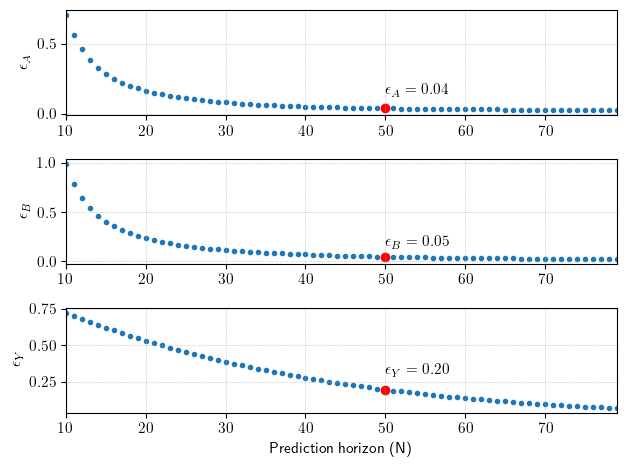

In [5]:

# Here we plot the system response that we have received from the previous block

Time_steps = np.arange(low_range_N, up_range_N).reshape(1, -1)

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 11})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42









# these are just second tries; either pick above or below and not both of them. 




fig1 = plt.figure()

ax = fig1.subplots(3,1)



# plot here
ax[0].scatter(Time_steps, Error_A, color='tab:blue', marker = '.')
ax[1].scatter(Time_steps, Error_B,color='tab:blue', marker = '.')
ax[2].scatter(Time_steps, Error_Y,color='tab:blue', marker = '.')



ax[0].scatter(Time_steps[[0], 40], Error_A[[0], 40], color='red', marker = 'o')
ax[1].scatter(Time_steps[[0], 40], Error_B[[0], 40], color='red', marker = 'o')
ax[2].scatter(Time_steps[[0], 40], Error_Y[[0], 40], color='red', marker = 'o')

ax[0].text(Time_steps[[0], 40],  0.1 + Error_A[[0], 40], "$\epsilon_A = {:.2f}$".format(Error_A[[0], 40][0]), usetex=True)
ax[1].text(Time_steps[[0], 40],  0.1 + Error_B[[0], 40], "$\epsilon_B = {:.2f}$".format(Error_B[[0], 40][0]), usetex=True)
ax[2].text(Time_steps[[0], 40],  0.1 + Error_Y[[0], 40], "$\epsilon_Y = {:.2f}$".format(Error_Y[[0], 40][0]), usetex=True)


ax[0].set_ylabel(r"$\epsilon_A $")
ax[1].set_ylabel(r"$\epsilon_B $")
ax[2].set_ylabel(r"$\epsilon_Y $")
ax[-1].set_xlabel("Prediction horizon (N)")

ax[0].set_xlim(Time_steps[:,0], Time_steps[:,-1])
ax[1].set_xlim(Time_steps[:,0], Time_steps[:,-1])
ax[-1].set_xlim(Time_steps[:,0], Time_steps[:,-1])


ax[0].grid(linestyle='dotted', linewidth=0.5)
ax[1].grid(linestyle='dotted', linewidth=0.5)
ax[2].grid(linestyle='dotted', linewidth=0.5)


plt.tight_layout()


# save the figure here



fig1.savefig("error_estimation.pdf", transparent=True, dpi=300)

[[-4.52252091+0.j  9.50786247+0.j  3.16083691+0.j  2.17452906+0.j
   1.78227086+0.j  1.57578505+0.j  1.45076892+0.j  1.36845504+0.j
   1.31116386+0.j  1.26970275+0.j  1.23883199+0.j  1.21535426+0.j
   1.19721293+0.j  1.18302826+0.j  1.17184217+0.j  1.16296998+0.j
   1.1559102 +0.j  1.15028767+0.j  1.14581649+0.j  1.14227514+0.j
   1.13948947+0.j  1.13732073+0.j  1.13565705+0.j  1.13440723+0.j
   1.1334962 +0.j  1.13286161+0.j  1.13245124+0.j  1.13222103+0.j
   1.13213357+0.j  1.13215692+0.j  1.13226365+0.j  1.13243015+0.j
   1.13263596+0.j  1.13286335+0.j  1.13309694+0.j  1.13332334+0.j
   1.13353091+0.j  1.13370955+0.j  1.1338505 +0.j  1.13394621+0.j
   1.13399022+0.j  1.13397702+0.j  1.13390196+0.j  1.13376121+0.j
   1.13355166+0.j  1.13327084+0.j  1.13291691+0.j  1.1324886 +0.j
   1.13198515+0.j  1.13140629+0.j  1.13075218+0.j  1.13002343+0.j
   1.12922099+0.j  1.12834621+0.j  1.12740074+0.j  1.12638655+0.j
   1.12530587+0.j  1.12416119+0.j  1.12295523+0.j  1.12169092+0.j
   1.12037

/home/teimour/University/my_codes/Affine_transformation_QP_solver/venv/lib/python3.8/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


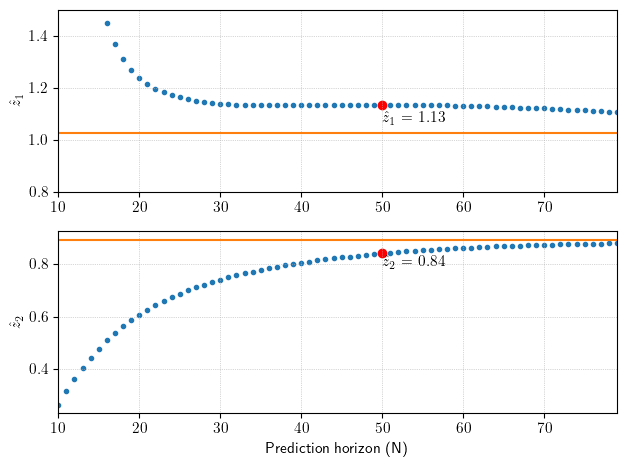

In [6]:
print(Zero_location)

# The true values for the zeros
Gd = ct.ss(A, B, C, D, dt=True)
z = ct.zeros(Gd)




fig2 = plt.figure()
# plt.style.use('seaborn-paper')
ax = fig2.subplots(2,1)



# plot here
ax[0].scatter(Time_steps, Zero_location[[0], :], color='tab:blue', marker = '.')
ax[1].scatter(Time_steps, Zero_location[[1], :], color='tab:blue', marker = '.')

ax[0].scatter(Time_steps[[0], 40], Zero_location[[0], 40], color='red', marker = 'o')
ax[1].scatter(Time_steps[[0], 40], Zero_location[[1], 40], color='red', marker = 'o')

ax[0].hlines(z[0].real, xmin=Time_steps[:,0], xmax=Time_steps[:,-1], linestyles='solid', colors='tab:orange')
ax[1].hlines(z[1].real, xmin=Time_steps[:,0], xmax=Time_steps[:,-1], linestyles='solid',  colors='tab:orange')
ax[0].text(Time_steps[[0], 40], - 0.07 + Zero_location[[0], 40].real,
            r"$\hat z_1$ = ${:.2f}$".format(Zero_location[[0], 40].real[0]), usetex=True)
ax[1].text(Time_steps[[0], 40], - 0.05 + Zero_location[[1], 40].real,
            r"$\hat z_2$ = ${:.2f}$".format(Zero_location[[1], 40].real[0]), usetex=True)



ax[0].set_ylabel(r"$\hat{z}_1$")
ax[1].set_ylabel(r"$\hat{z}_2$")
ax[-1].set_xlabel("Prediction horizon (N)")

ax[0].set_ylim(0.8, 1.5)

ax[0].set_xlim(Time_steps[:,0], Time_steps[:,-1])
ax[1].set_xlim(Time_steps[:,0], Time_steps[:,-1])
ax[0].grid(linestyle='dotted', linewidth=0.5)
ax[1].grid(linestyle='dotted', linewidth=0.5)

plt.tight_layout()





fig2.savefig("zero_location.pdf", transparent=True, dpi=800)

plt.show()

